In [1]:
from pathlib import Path
import sys

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
current_path = %pwd
current_path = Path(current_path)
sys.path.insert(0, str(current_path.parent))

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
from models import baseline_10x15

In [6]:
model_path = current_path.parent.joinpath("saved_models", "baseline_10x15")

generator = baseline_10x15.generator
generator.load_weights(model_path.joinpath('generator_09950.h5').as_posix())

In [7]:
from data import preprocessing

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
data = preprocessing.read_csv_2d()
unscale = lambda x: 10**x - 1

_, X_test = train_test_split(data, test_size=0.25, random_state=42)

In [10]:
X_gen = unscale(
    generator(
        np.random.normal(size=(len(X_test), baseline_10x15.LATENT_DIM)).astype('float32')
    ).numpy()
)

In [11]:
import matplotlib.pyplot as plt

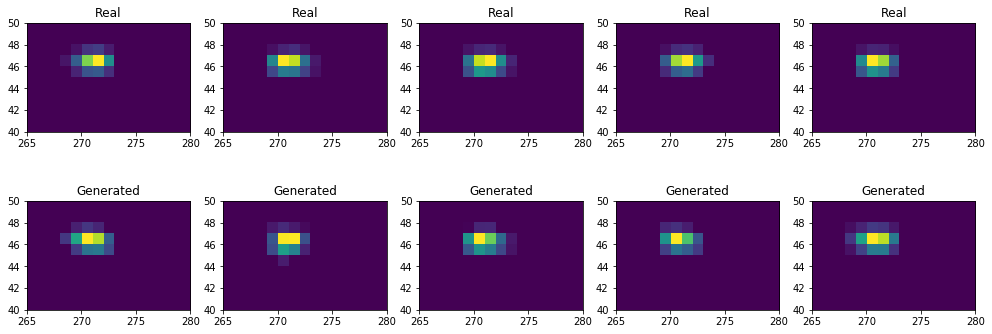

In [12]:
rnd_i = np.random.choice(len(X_test), size=5, replace=False)

plt.figure(figsize=(17, 6))
for i in range(len(rnd_i)):
    plt.subplot(2, len(rnd_i), i + 1)
    plt.imshow(X_test[rnd_i[i]], extent=(265, 280, 40, 50))
    plt.title("Real")
    
    plt.subplot(2, len(rnd_i), len(rnd_i) + i + 1)
    plt.imshow(X_gen[rnd_i[i]], extent=(265, 280, 40, 50))
    plt.title("Generated")


In [13]:
from metrics import get_val_metric, _METRIC_NAMES

In [14]:
X_gen_massive = unscale(
    generator(
        np.random.normal(size=(10000, baseline_10x15.LATENT_DIM)).astype('float32')
    ).numpy()
)

In [15]:
metrics_real = get_val_metric(X_test)
metrics_gen  = get_val_metric(np.where(X_gen_massive < 0, 0, X_gen_massive))

In [17]:
_METRIC_NAMES

['Mean0', 'Mean1', 'Sigma0^2', 'Sigma1^2', 'Cov01', 'Sum']

In [29]:
a = np.array([1,2,3,4])
print(np.std(a))
print(np.std(a, ddof=1))
print(((a - a.mean())**2).mean()**0.5 * (4/3)**0.5)

1.118033988749895
1.2909944487358056
1.2909944487358056


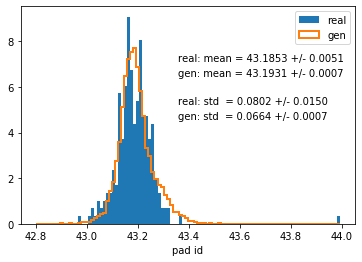

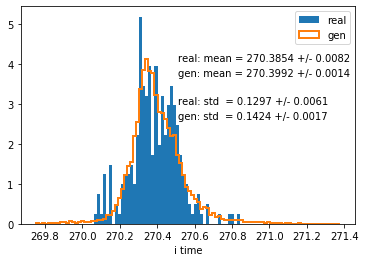

In [42]:
mean_padid_real = metrics_real[:,0] + 40
mean_padid_gen  = metrics_gen [:,0] + 40

mean_time_real = metrics_real[:,1] + 265
mean_time_gen  = metrics_gen [:,1] + 265

def bootstrap_error(data, function, num_bs=100):
    assert data.ndim == 1
    bs_data = np.random.choice(data, size=(num_bs, len(data)), replace=True)
    return np.array([function(bs_sample) for bs_sample in bs_data]).std()

def get_stats(arr):
    class Obj:
        pass
    result = Obj()
    
    result.mean = arr.mean()
    result.width = arr.std()
    
    result.mean_err = result.width / (len(arr) - 1)**0.5
    result.width_err = bootstrap_error(arr, np.std)
    
    return result

def compare_two_dists(d_real, d_gen, label, nbins=100):
    fig, ax = plt.subplots()
    bins = np.linspace(
        min(d_real.min(), d_gen.min()),
        max(d_real.max(), d_gen.max()),
        nbins + 1
    )
    
    stats_real = get_stats(d_real)
    stats_gen  = get_stats(d_gen )
    
    plt.hist(d_real, bins=bins, density=True, label='real')
    plt.hist(d_gen , bins=bins, density=True, label='gen', histtype='step', linewidth=2.)
    plt.text(0.47, 0.75, "real: mean = {:.4f} +/- {:.4f}".format(stats_real.mean , stats_real.mean_err ), transform=ax.transAxes)
    plt.text(0.47, 0.68, "gen: mean = {:.4f} +/- {:.4f}".format(stats_gen .mean , stats_gen .mean_err ), transform=ax.transAxes)
    plt.text(0.47, 0.55, "real: std  = {:.4f} +/- {:.4f}".format(stats_real.width, stats_real.width_err), transform=ax.transAxes)
    plt.text(0.47, 0.48, "gen: std  = {:.4f} +/- {:.4f}".format(stats_gen .width, stats_gen .width_err), transform=ax.transAxes)
    plt.xlabel(label)
    plt.legend()
    return fig

compare_two_dists(mean_padid_real, mean_padid_gen, 'pad id')
compare_two_dists(mean_time_real , mean_time_gen , 'i time');